In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
strategy = tf.distribute.MirroredStrategy()
print('Chúng ta đang sử dụng ', strategy.num_replicas_in_sync, ' GPU!')

Chúng ta đang sử dụng  1  GPU!


In [3]:
tf.random.set_seed(143)


In [4]:
# Define some constants
img_height = 80
img_width = 80
batch_size = 16

In [5]:
# Load dataset
data, info = tfd.load('imagenette/160px-v2', with_info=True, as_supervised=True)

In [6]:
train_data, val_data = data['train'], data['validation']

In [7]:
num_classes = info.features['label'].num_classes
print(f'There are {num_classes} in the dataset.')

There are 10 in the dataset.


In [8]:
label_name = info.features['label'].int2str
text_label = [label_name(i) for i in range(10)]
text_label

['n01440764',
 'n02102040',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257']

In [9]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [10]:
def resize_decode(image, label):
    img = tf.image.resize(image, [img_height, img_width])
    return img, label
# Map label name
def get_label_name(fname):
    return lbl_dict[fname]

In [11]:
# Resize images
train_data = train_data.map(resize_decode)
val_data = val_data.map(resize_decode)

In [12]:
full_data = train_data.concatenate(val_data)
full_data = full_data.shuffle(len(full_data))

In [13]:
full_size = int(len(full_data) * 1)
train_size = int(full_size * 0.7)
val_size = int(full_size * 0.15)
test_size = int(full_size * 0.15)


In [14]:
train_data = full_data.take(train_size)
test_data = full_data.skip(train_size)
val_data = test_data.skip(val_size)
test_data = test_data.take(test_size)

In [15]:
print('Number of train samples: ', len(train_data))
print('Number of validation samples: ', len(val_data))
print('Number of test samples: ', len(test_data))

Number of train samples:  9375
Number of validation samples:  2010
Number of test samples:  2009


In [16]:
ori_train_set = (train_data.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))
ori_val_set = (val_data.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))
ori_test_set = (test_data.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))

In [17]:
uint_train_set = (train_data.map(lambda x, y: (tf.cast(x, dtype=tf.uint8), y))
                 .batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))
uint_val_set = (val_data.map(lambda x, y: (tf.cast(x, dtype=tf.uint8), y))
               .batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))
uint_test_set = (test_data.map(lambda x, y: (tf.cast(x, dtype=tf.uint8), y))
                .batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))

In [18]:
normed_train_set_f = (train_data.map(lambda x, y: ((x / 255.0), y))
                    .batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))
normed_val_set_f = (val_data.map(lambda x, y: ((x / 255.0), y))
                  .batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))
normed_test_set_f = (test_data.map(lambda x, y: ((x / 255.0), y))
                   .batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))

In [19]:
float_train_set_fromuint = (uint_train_set.map(lambda x, y: (tf.cast(x, dtype=tf.float32), y))
                    .prefetch(buffer_size=tf.data.AUTOTUNE))
float_val_set_fromuint = (uint_val_set.map(lambda x, y: (tf.cast(x, dtype=tf.float32), y))
                 .prefetch(buffer_size=tf.data.AUTOTUNE))
float_test_set_fromuint = (uint_test_set.map(lambda x, y: (tf.cast(x, dtype=tf.float32), y))
                   .prefetch(buffer_size=tf.data.AUTOTUNE))

In [20]:
len(uint_train_set)

586

In [21]:
normed_train_set_i = (float_train_set_fromuint.map(lambda x, y: ((x / 255.0), y))
                   .prefetch(buffer_size=tf.data.AUTOTUNE))
normed_val_set_i = (float_val_set_fromuint.map(lambda x, y: ((x / 255.0), y))
                  .prefetch(buffer_size=tf.data.AUTOTUNE))
normed_test_set_i = (float_test_set_fromuint.map(lambda x, y: ((x / 255.0), y))
                .prefetch(buffer_size=tf.data.AUTOTUNE))

In [22]:
len(normed_train_set_i)

586

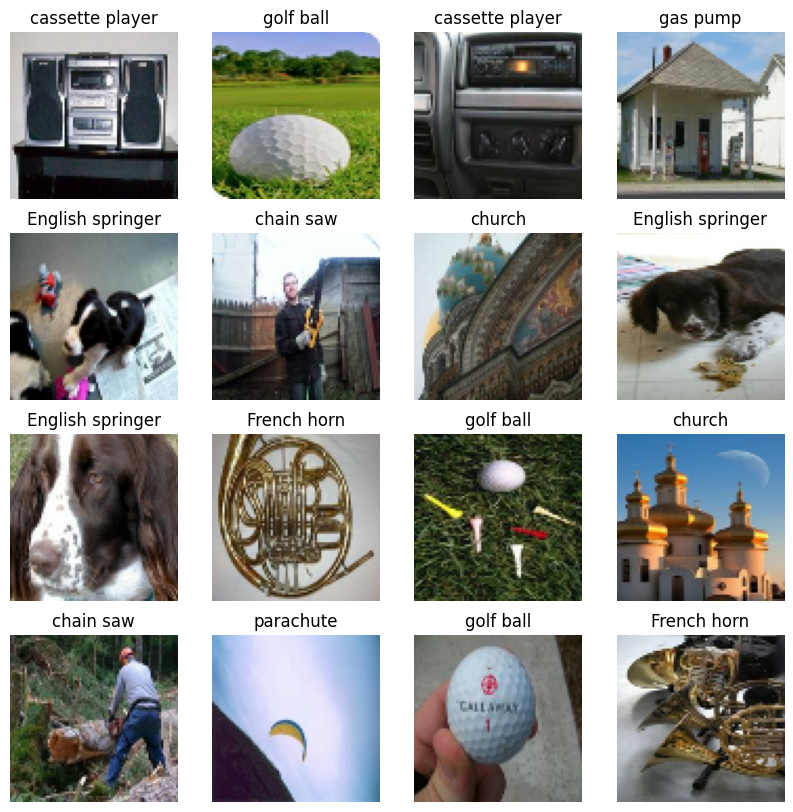

In [23]:
# Visualize some samples of original train set
_, ax = plt.subplots(4, 4, figsize=(10, 10))
for train in ori_train_set.take(1):

  for i in range(16):
      label = (train[1][i].numpy())
      # print(train[1].numpy())
      label = text_label[label]
      label = get_label_name(label)

      ax[i // 4, i % 4].imshow(tf.cast(train[0][i, :, :, :], dtype=tf.uint8))
      ax[i // 4, i % 4].set_title(label)
      ax[i // 4, i % 4].axis('off')
plt.show()

In [24]:
def build_model(lr):
    input_img = tf.keras.layers.Input(shape=(img_height, img_width, 3))
    x = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.layers.LeakyReLU(), padding='same')(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(), padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU())(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU())(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    output = tf.keras.layers.Dense(10, activation='softmax')(x)
    model = tf.keras.Model(input_img, output)
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=opt, loss=loss_fn, metrics=['acc'])
    return model

In [25]:
with strategy.scope():
    ori_model = build_model(0.001)
ori_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 80, 80, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 64)               0     

In [26]:
val_step = len(ori_val_set) // batch_size

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)


In [28]:
ori_model.fit(ori_train_set, validation_data=ori_val_set, validation_steps=val_step, epochs=50, callbacks=[callback],)

Epoch 1/50
586/586 [==============================] - 18s 14ms/step - loss: 2.7719 - acc: 0.2207 - val_loss: 2.0445 - val_acc: 0.2679
Epoch 2/50
586/586 [==============================] - 8s 12ms/step - loss: 1.9497 - acc: 0.3159 - val_loss: 1.6510 - val_acc: 0.3750
Epoch 3/50
586/586 [==============================] - 8s 12ms/step - loss: 1.8472 - acc: 0.3619 - val_loss: 1.7492 - val_acc: 0.3929
Epoch 4/50
586/586 [==============================] - 8s 11ms/step - loss: 1.7460 - acc: 0.4050 - val_loss: 1.3751 - val_acc: 0.5804
Epoch 5/50
586/586 [==============================] - 8s 11ms/step - loss: 1.7136 - acc: 0.4127 - val_loss: 1.4769 - val_acc: 0.4643
Epoch 6/50
586/586 [==============================] - 7s 10ms/step - loss: 1.6334 - acc: 0.4544 - val_loss: 1.8712 - val_acc: 0.3929
Epoch 7/50
586/586 [==============================] - 9s 13ms/step - loss: 1.6199 - acc: 0.4513 - val_loss: 1.5151 - val_acc: 0.5357
Epoch 8/50
586/586 [==============================] - 9s 12ms/step -

In [29]:
with strategy.scope():
    uint_model = build_model(0.001)
uint_model.fit(uint_train_set, validation_data=uint_val_set, validation_steps=val_step, epochs=50, callbacks=[callback],)

Epoch 1/50
586/586 [==============================] - 11s 11ms/step - loss: 2.5616 - acc: 0.2164 - val_loss: 2.0088 - val_acc: 0.2321
Epoch 2/50
586/586 [==============================] - 8s 12ms/step - loss: 1.9853 - acc: 0.2960 - val_loss: 1.6049 - val_acc: 0.5446
Epoch 3/50
586/586 [==============================] - 7s 10ms/step - loss: 1.8539 - acc: 0.3605 - val_loss: 1.7062 - val_acc: 0.4107
Epoch 4/50
586/586 [==============================] - 10s 12ms/step - loss: 1.7488 - acc: 0.4065 - val_loss: 1.7817 - val_acc: 0.4107
Epoch 5/50
586/586 [==============================] - 9s 13ms/step - loss: 1.6649 - acc: 0.4359 - val_loss: 1.4591 - val_acc: 0.5089
Epoch 6/50
586/586 [==============================] - 9s 12ms/step - loss: 1.6446 - acc: 0.4473 - val_loss: 1.4793 - val_acc: 0.4196
Epoch 7/50
586/586 [==============================] - 8s 12ms/step - loss: 1.5942 - acc: 0.4656 - val_loss: 1.4086 - val_acc: 0.5446
Epoch 8/50
586/586 [==============================] - 9s 11ms/step 

In [30]:
with strategy.scope():
    normed_model_f = build_model(0.001)
normed_model_f.fit(normed_train_set_f, validation_data=normed_val_set_f, validation_steps=val_step, epochs=50, callbacks=[callback],)

Epoch 1/50
586/586 [==============================] - 11s 13ms/step - loss: 2.1373 - acc: 0.2201 - val_loss: 2.1135 - val_acc: 0.2768
Epoch 2/50
586/586 [==============================] - 8s 12ms/step - loss: 1.9645 - acc: 0.2914 - val_loss: 1.8630 - val_acc: 0.3661
Epoch 3/50
586/586 [==============================] - 8s 12ms/step - loss: 1.8623 - acc: 0.3365 - val_loss: 1.9006 - val_acc: 0.3393
Epoch 4/50
586/586 [==============================] - 8s 11ms/step - loss: 1.7776 - acc: 0.3809 - val_loss: 1.8210 - val_acc: 0.2946
Epoch 5/50
586/586 [==============================] - 8s 11ms/step - loss: 1.7085 - acc: 0.4111 - val_loss: 1.6722 - val_acc: 0.4018
Epoch 6/50
586/586 [==============================] - 8s 12ms/step - loss: 1.6547 - acc: 0.4302 - val_loss: 1.5721 - val_acc: 0.4643
Epoch 7/50
586/586 [==============================] - 8s 10ms/step - loss: 1.6089 - acc: 0.4430 - val_loss: 1.4154 - val_acc: 0.5536
Epoch 8/50
586/586 [==============================] - 8s 11ms/step -

In [ ]:
with strategy.scope():
    normed_model_i = build_model(0.001)
normed_model_i.fit(normed_train_set_i, validation_data=normed_val_set_i, validation_steps=val_step, epochs=50, callbacks=[callback],)

In [32]:
def predict_test_data(model, dataset):
    y_true = []
    y_pred = []
    for test in dataset.take(len(ori_test_set)):
        imgs = test[0]
        y_true.extend(test[1])
        preds = model.predict(imgs, verbose=None)
        preds = np.argmax(preds, axis=1)
        y_pred.extend(preds)
    return y_true, y_pred


In [ ]:
ori_y = predict_test_data(ori_model, ori_test_set)
uint_y = predict_test_data(uint_model, uint_test_set)
normed_y_f = predict_test_data(normed_model_f, normed_test_set_f)
normed_y_i = predict_test_data(normed_model_i, normed_test_set_i)

In [34]:
print('Accuracy on original test set (with original train set) (dtype=float32): ', accuracy_score(ori_y[0], ori_y[1]))
print('Accuracy on original test set (with original train set) (dtype=uint8): ', accuracy_score(uint_y[0], uint_y[1]))
print('Accuracy on normalized test set (with normalized train set) (normalized on float32 data): ', accuracy_score(normed_y_f[0], normed_y_f[1]))
print('Accuracy on normalized test set (with normalized train set) (normalized on uint8 data): ', accuracy_score(normed_y_i[0], normed_y_i[1]))

Accuracy on original test set (with original train set) (dtype=float32):  0.4698855151816824
Accuracy on original test set (with original train set) (dtype=uint8):  0.6112493777999004
Accuracy on normalized test set (with normalized train set) (normalized on float32 data):  0.5898456943753111
Accuracy on normalized test set (with normalized train set) (normalized on uint8 data):  0.6301642608262817
